# Optimizaciones de GCC

En estos apuntes se presentan gráficas de los tiempos de ejecución, para una función que suma los elementos de dos arreglos de vectores y almacena el resultado en otro vector. La función será compilada con optimizaciones para observar como estas afectan al tiempo de ejecución y a la precisión. 

## Dependencias

In [1]:
import ctypes
import numpy
from numpy import linalg as LA

## Suma de arreglos de floats

In [2]:
%%file vectorFloatAdd.c
// funcion que suma dos arrays de floats
void vectorFloatAdd(float* a, float* b, float* c, int size){
    for(int i = 0; i < size; i++){
        c[i] = a[i] + b[i];
    }
}

Writing vectorFloatAdd.c


In [3]:
# crear el object file
! gcc -c -Wall -Werror -fpic -O0 vectorFloatAdd.c -o vectorFloatAddO0.o
! gcc -c -Wall -Werror -fpic -O1 vectorFloatAdd.c -o vectorFloatAddO1.o
! gcc -c -Wall -Werror -fpic -O2 vectorFloatAdd.c -o vectorFloatAddO2.o
! gcc -c -Wall -Werror -fpic -O3 vectorFloatAdd.c -o vectorFloatAddO3.o
! gcc -c -Wall -Werror -fpic -Os vectorFloatAdd.c -o vectorFloatAddOs.o

# crear la shared library
! gcc -shared vectorFloatAddO0.o -o _vectorFloatAddO0.so
! gcc -shared vectorFloatAddO1.o -o _vectorFloatAddO1.so
! gcc -shared vectorFloatAddO2.o -o _vectorFloatAddO2.so
! gcc -shared vectorFloatAddO3.o -o _vectorFloatAddO3.so
! gcc -shared vectorFloatAddOs.o -o _vectorFloatAddOs.so

In [4]:
# con este comando puede ver el disassembly del object file que le de curiosidad
! objdump -M intel -j .text -D vectorFloatAddO1.o


vectorFloatAddO1.o:     file format elf64-x86-64


Disassembly of section .text:

0000000000000000 <vectorFloatAdd>:
   0:	f3 0f 1e fa          	endbr64 
   4:	85 c9                	test   ecx,ecx
   6:	7e 24                	jle    2c <vectorFloatAdd+0x2c>
   8:	44 8d 41 ff          	lea    r8d,[rcx-0x1]
   c:	b8 00 00 00 00       	mov    eax,0x0
  11:	f3 0f 10 04 87       	movss  xmm0,DWORD PTR [rdi+rax*4]
  16:	f3 0f 58 04 86       	addss  xmm0,DWORD PTR [rsi+rax*4]
  1b:	f3 0f 11 04 82       	movss  DWORD PTR [rdx+rax*4],xmm0
  20:	48 89 c1             	mov    rcx,rax
  23:	48 83 c0 01          	add    rax,0x1
  27:	4c 39 c1             	cmp    rcx,r8
  2a:	75 e5                	jne    11 <vectorFloatAdd+0x11>
  2c:	c3                   	ret    


In [5]:
! objdump -M intel -j .text -D vectorFloatAddO2.o


vectorFloatAddO2.o:     file format elf64-x86-64


Disassembly of section .text:

0000000000000000 <vectorFloatAdd>:
   0:	f3 0f 1e fa          	endbr64 
   4:	85 c9                	test   ecx,ecx
   6:	7e 23                	jle    2b <vectorFloatAdd+0x2b>
   8:	44 8d 41 ff          	lea    r8d,[rcx-0x1]
   c:	31 c0                	xor    eax,eax
   e:	66 90                	xchg   ax,ax
  10:	f3 0f 10 04 87       	movss  xmm0,DWORD PTR [rdi+rax*4]
  15:	f3 0f 58 04 86       	addss  xmm0,DWORD PTR [rsi+rax*4]
  1a:	48 89 c1             	mov    rcx,rax
  1d:	f3 0f 11 04 82       	movss  DWORD PTR [rdx+rax*4],xmm0
  22:	48 83 c0 01          	add    rax,0x1
  26:	4c 39 c1             	cmp    rcx,r8
  29:	75 e5                	jne    10 <vectorFloatAdd+0x10>
  2b:	c3                   	ret    


In [6]:
! objdump -M intel -j .text -D vectorFloatAddOs.o


vectorFloatAddOs.o:     file format elf64-x86-64


Disassembly of section .text:

0000000000000000 <vectorFloatAdd>:
   0:	f3 0f 1e fa          	endbr64 
   4:	31 c0                	xor    eax,eax
   6:	39 c1                	cmp    ecx,eax
   8:	7e 14                	jle    1e <vectorFloatAdd+0x1e>
   a:	f3 0f 10 04 87       	movss  xmm0,DWORD PTR [rdi+rax*4]
   f:	f3 0f 58 04 86       	addss  xmm0,DWORD PTR [rsi+rax*4]
  14:	f3 0f 11 04 82       	movss  DWORD PTR [rdx+rax*4],xmm0
  19:	48 ff c0             	inc    rax
  1c:	eb e8                	jmp    6 <vectorFloatAdd+0x6>
  1e:	c3                   	ret    


In [7]:
def ctypes_vector_float_add(libfile):
    # cargar la shared library
    lib = ctypes.CDLL(libfile)
    # tipo de dato de los argumentos
    lib.vectorFloatAdd.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        ctypes.c_int
    ]
     # funcion configurada
    return lib.vectorFloatAdd

In [8]:
cvfaddO0 = ctypes_vector_float_add('./_vectorFloatAddO0.so')
cvfaddO1 = ctypes_vector_float_add('./_vectorFloatAddO1.so')
cvfaddO2 = ctypes_vector_float_add('./_vectorFloatAddO2.so')
cvfaddO3 = ctypes_vector_float_add('./_vectorFloatAddO3.so')
cvfaddOs = ctypes_vector_float_add('./_vectorFloatAddOs.so')

### Comparación de los errores relativos y tiempos de ejecución

In [9]:
import statistics

def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

In [10]:
# modulo para graficar
import matplotlib.pyplot as plt

# modulo para medir el tiempo
import time

# tamagnos de los arreglos
sizes = 2**numpy.arange(11,18)

# errores de la suma de arreglos de floats
eo0 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

eo1 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

eo2 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

eo3 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

eos = numpy.zeros((len(sizes),1),dtype=numpy.float64)

# tiempos de la suma de arreglos de floats
to0 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

to1 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

to2 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

to3 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

tos = numpy.zeros((len(sizes),1),dtype=numpy.float64)

# repeticiones
veces = 100

In [11]:
# mediciones de los errores relativos con cada optimización
e0i = []
e1i = []
e2i = []
e3i = []
esi = []

for i, size in enumerate(sizes):
    e0i = []
    e1i = []
    e2i = []
    e3i = []
    esi = []
    for j in range(veces):
        # entradas
        x = numpy.random.rand(size,1).astype(numpy.float32)
        y = numpy.random.rand(size,1).astype(numpy.float32)
        
        # salidas
        z0 = numpy.zeros((size,1),dtype=numpy.float32)
        z1 = numpy.zeros((size,1),dtype=numpy.float32)
        z2 = numpy.zeros((size,1),dtype=numpy.float32)
        z3 = numpy.zeros((size,1),dtype=numpy.float32)
        zs = numpy.zeros((size,1),dtype=numpy.float32)
        
        # referencia
        z = numpy.zeros((size,1),dtype=numpy.float32)
        z = x + y
    
        # error relativo O0
        cvfaddO0(x,y,z0,size)
        e0i.append(LA.norm(z - z0) / LA.norm(z))
        
        # error relativo O1
        cvfaddO1(x,y,z1,size)
        e1i.append(LA.norm(z - z1) / LA.norm(z))
        
        # error relativo O2
        cvfaddO2(x,y,z2,size)
        e2i.append(LA.norm(z - z2) / LA.norm(z))
        
        # error relativo O3
        cvfaddO3(x,y,z3,size)
        e3i.append(LA.norm(z - z3) / LA.norm(z))
        
        # error relativo Os
        cvfaddOs(x,y,zs,size)
        esi.append(LA.norm(z - zs) / LA.norm(z))
        
    eo0[i] = statistics.mean(e0i)
    eo1[i] = statistics.mean(e1i)
    eo2[i] = statistics.mean(e2i)
    eo3[i] = statistics.mean(e3i)
    eos[i] = statistics.mean(esi)

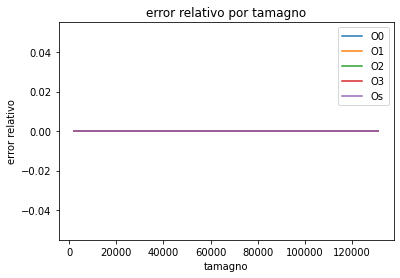

In [12]:
plt.plot(sizes, eo0, label='O0')
plt.plot(sizes, eo1, label='O1')
plt.plot(sizes, eo2, label='O2')
plt.plot(sizes, eo3, label='O3')
plt.plot(sizes, eos, label='Os')
plt.title('error relativo por tamagno')
plt.xlabel('tamagno')
plt.ylabel('error relativo')
plt.legend()
plt.show()

In [13]:
# luego de comprobar que todas las funciones son precisas
# se pueden realizar mediciones de tiempo para cada tamagno

t0i = []
t1i = []
t2i = []
t3i = []
tsi = []

for i, size in enumerate(sizes):
    t0i = []
    t1i = []
    t2i = []
    t3i = []
    tsi = []
    for j in range(veces):
        # entradas
        x = numpy.random.rand(size,1).astype(numpy.float32)
        y = numpy.random.rand(size,1).astype(numpy.float32)
    
        # salida
        z =  numpy.zeros((size,1),dtype=numpy.float32)
    
        # tiempo O0
        t = time.time()
        cvfaddO0(x,y,z,size)
        t0i.append(time.time() - t)
        
        # tiempo O1
        t = time.time()
        cvfaddO1(x,y,z,size)
        t1i.append(time.time() - t)
        
        # tiempo O2
        t = time.time()
        cvfaddO2(x,y,z,size)
        t2i.append(time.time() - t)
        
        # tiempo O3
        t = time.time()
        cvfaddO3(x,y,z,size)
        t3i.append(time.time() - t)
        
        # tiempo Os
        t = time.time()
        cvfaddOs(x,y,z,size)
        tsi.append(time.time() - t)
        
    to0[i] = statistics.mean(filtro_mediana(t0i,7))
    to1[i] = statistics.mean(filtro_mediana(t1i,7))
    to2[i] = statistics.mean(filtro_mediana(t2i,7))
    to3[i] = statistics.mean(filtro_mediana(t3i,7))
    tos[i] = statistics.mean(filtro_mediana(tsi,7))

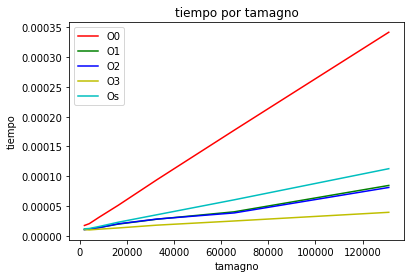

In [14]:
plt.plot(sizes, to0, 'r', label='O0')
plt.plot(sizes, to1, 'g', label='O1')
plt.plot(sizes, to2, 'b', label='O2')
plt.plot(sizes, to3, 'y', label='O3')
plt.plot(sizes, tos, 'c', label='Os')
plt.title('tiempo por tamagno')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.show()

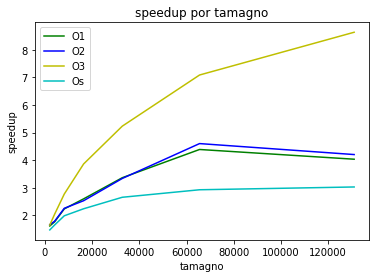

In [15]:
plt.plot(sizes, to0/to1, 'g', label='O1')
plt.plot(sizes, to0/to2, 'b', label='O2')
plt.plot(sizes, to0/to3, 'y', label='O3')
plt.plot(sizes, to0/tos, 'c', label='Os')
plt.title('speedup por tamagno')
plt.xlabel('tamagno')
plt.ylabel('speedup')
plt.legend()
plt.show()

In [16]:
! rm *.o
! rm *.so
! rm *.c